In [1]:
from typing import Callable, Any
import glob
import json
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

DATASET = "compas"

In [2]:
formatting = {
    "risan": {
        "color": "black",
        "linestyle": "-",
        "marker": ".",
        "label": "RISAN",
        "alpha": 0.4,
    },
    "risan g0": {
        "color": "black",
        "linestyle": "-",
        "marker": ".",
        "label": "RISAN group 0",
        "alpha": 0.4,
    },
    "risan g1": {
        "color": "black",
        "linestyle": "--",
        "marker": "x",
        "label": "RISAN group 1",
        "alpha": 0.4,
    },
    "eq risan": {
        "color": "blue",
        "linestyle": "-",
        "marker": ".",
        "label": "EQUISCALE RISAN",
        "alpha": 0.4,
    },
    "eq risan g0": {
        "color": "blue",
        "linestyle": "-",
        "marker": ".",
        "label": "EQUISCALE RISAN group 0",
        "alpha": 0.4,
    },
    "eq risan g1": {
        "color": "blue",
        "linestyle": "--",
        "marker": "x",
        "label": "EQUISCALE RISAN group 1",
        "alpha": 0.4,
    },

    "kp1": {
        "color": "red",
        "linestyle": "-",
        "marker": ".",
        "label": "KP1",
        "alpha": 0.4,
    },
    "kp1 g0": {
        "color": "red",
        "linestyle": "-",
        "marker": ".",
        "label": "KP1 group 0",
        "alpha": 0.4,
    },
    "kp1 g1": {
        "color": "red",
        "linestyle": "--",
        "marker": "x",
        "label": "KP1 group 1",
        "alpha": 0.4,
    },
    "eq kp1": {
        "color": "darkorange",
        "linestyle": "-",
        "marker": ".",
        "label": "EQUISCALE KP1",
        "alpha": 0.4,
    },
    "eq kp1 g0": {
        "color": "darkorange",
        "linestyle": "-",
        "marker": ".",
        "label": "EQUISCALE KP1 group 0",
        "alpha": 0.4,
    },
    "eq kp1 g1": {
        "color": "darkorange",
        "linestyle": "--",
        "marker": "x",
        "label": "EQUISCALE KP1 group 1",
        "alpha": 0.4,
    },

    "dpabst": {
        "color": "green",
        "linestyle": "-",
        "marker": ".",
        "label": "DPABST",
        "alpha": 0.4,
    },
    "dpabst g0": {
        "color": "green",
        "linestyle": "-",
        "marker": ".",
        "label": "DPABST group 0",
        "alpha": 0.4,
    },
    "dpabst g1": {
        "color": "green",
        "linestyle": "--",
        "marker": "x",
        "label": "DPABST group 1",
        "alpha": 0.4,
    },
}

In [3]:
def plot_with_std(x_vals: pd.Series, y_vals: pd.Series, y_std: pd.Series, formatting):
    plot_kwargs = formatting.copy()
    del plot_kwargs["alpha"]
    fill_kwargs = formatting.copy()
    del fill_kwargs["label"]
    del fill_kwargs["marker"]
    plt.plot(x_vals, y_vals, **plot_kwargs)
    lower = ((y_vals - y_std).to_numpy()).clip(min=0, max=100)
    upper = ((y_vals + y_std).to_numpy()).clip(min=0, max=100)
    plt.fill_between(x_vals, lower, upper, **fill_kwargs)


def plot_without_std(x_vals, y_vals, formatting):
    plot_kwargs = formatting.copy()
    del plot_kwargs["alpha"]
    plt.plot(x_vals, y_vals, **plot_kwargs)

In [4]:
def plots(dataframes: dict[str, pd.DataFrame], metric: str, std: bool, groupwise: bool, diff: bool):
    for key in dataframes:
        if dataframes[key].empty:
            continue
        if std:
            if groupwise:
                plot_with_std(
                    dataframes[key]["cov_avg"],
                    dataframes[key][f"{metric}_0_avg"],
                    dataframes[key][f"{metric}_0_std"],
                    formatting[f"{key} g0"],
                )
                plot_with_std(
                    dataframes[key]["cov_avg"],
                    dataframes[key][f"{metric}_1_avg"],
                    dataframes[key][f"{metric}_1_std"],
                    formatting[f"{key} g1"],
                )
            else:
                plot_with_std(
                    dataframes[key]["cov_avg"],
                    dataframes[key][f"{metric}_avg"],
                    dataframes[key][f"{metric}_std"],
                    formatting[f"{key}"],
                )
        else: # Difference plots
            if diff:
                plot_without_std(
                    dataframes[key]["cov_avg"],
                    abs(dataframes[key][f"{metric}_0_avg"] - dataframes[key][f"{metric}_1_avg"]),
                    formatting[f"{key}"],
                )

In [ ]:
def print_table(
    dataframes: dict[str, pd.DataFrame], metrics: list[str], agr: Callable[[Any], Any]
):
    entries = {"model": []}
    for metric in metrics:
        entries[metric] = []
    for key in dataframes.keys():
        if dataframes[key].empty:
            continue
        entries["model"].append(key)
        for metric in metrics:
            entries[metric].append(
                np.round(
                    agr(
                        np.abs(
                            dataframes[key][f"{metric}_0_avg"]
                            - dataframes[key][f"{metric}_1_avg"]
                        )
                    ),
                    2,
                )
            )
    df = pd.DataFrame.from_dict(entries)
    print(df)

# TODO: Latex table output

# Independence section

In [6]:
risan_pd = pd.DataFrame()
eq_risan_pd = pd.DataFrame()
kp1_pd = pd.DataFrame()
eq_kp1_pd = pd.DataFrame()
dpabst_pd = pd.DataFrame()

for file in glob.glob("results/*.json"):
    args = file.split("_")
    dataset = args[0].split("/")[1]
    if dataset != DATASET:
        continue
    model = args[2]
    fairness_conditions = args[1]
    if model == "dpabst":
        cov = args[3].split(".json")[0]
        record = {}
        with open(file, "r") as f:
            data = json.load(f)
        for key in data.keys():
            record[f"{key}_avg"] = round(data[key][0], 2)
            record[f"{key}_std"] = round(data[key][1], 2)
        temp = pd.Series(record)
        temp = temp.to_frame().T
        dpabst_pd = pd.concat([dpabst_pd, temp])
    elif fairness_conditions != "abs-neg-pos":
        continue
    else:
        pass

dataframes: dict[str, pd.DataFrame] = {
    "risan": risan_pd,
    "eq risan": eq_risan_pd,
    "kp1": kp1_pd,
    "eq kp1": eq_kp1_pd,
    "dpabst": dpabst_pd,
}

for key in list(dataframes.keys()):
    if dataframes[key].empty:
        continue
    dataframes[key] = dataframes[key].sort_values(by="cov_avg")


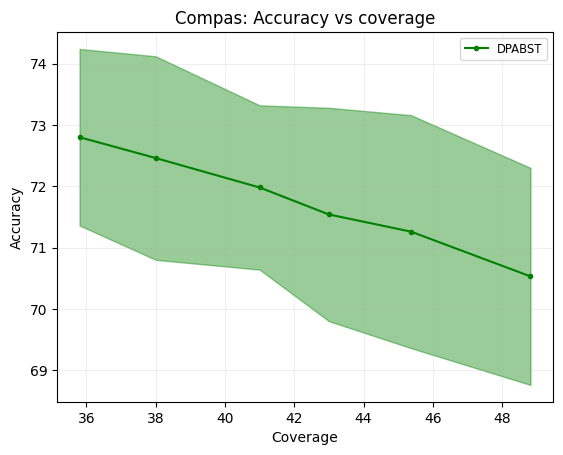

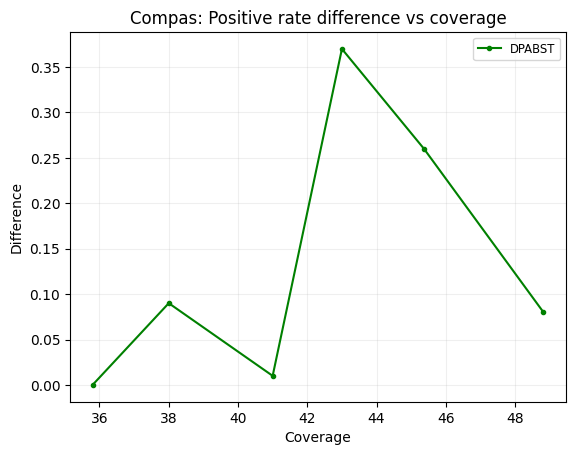

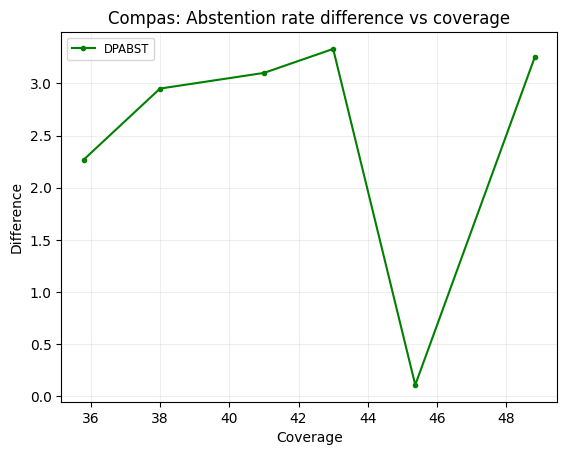

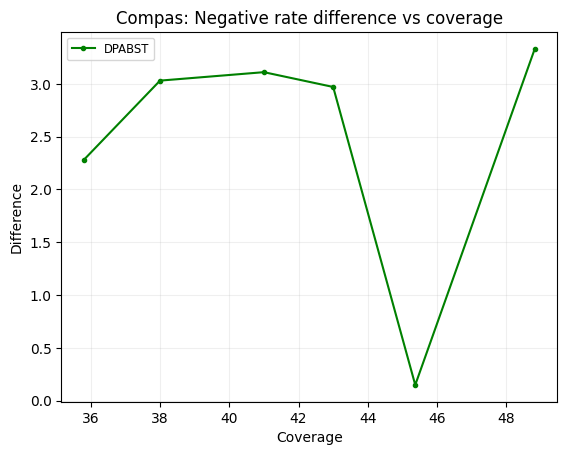

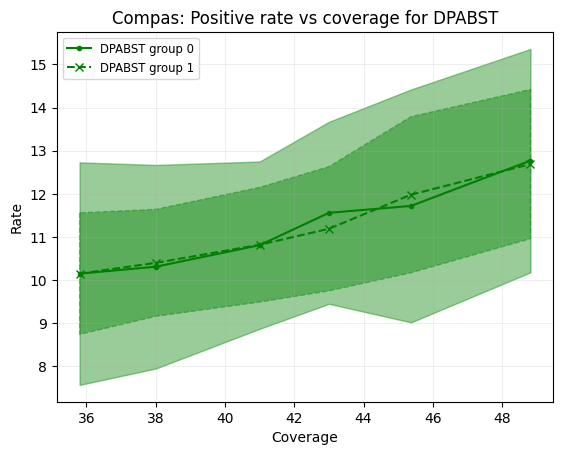

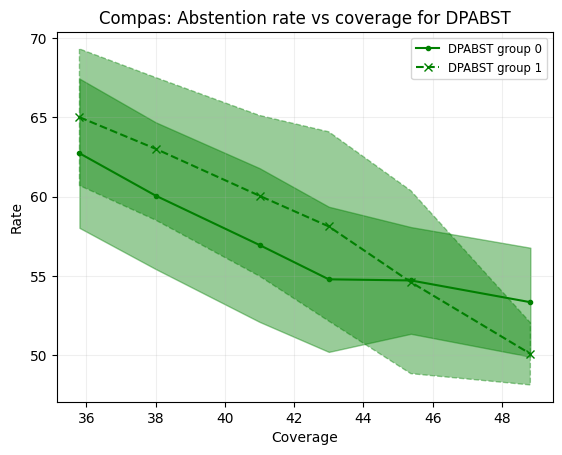

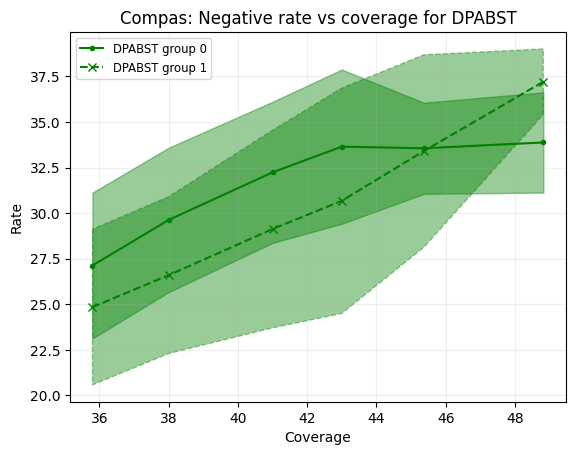

/tmp/ipykernel_143586/1727330689.py:69: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="small")


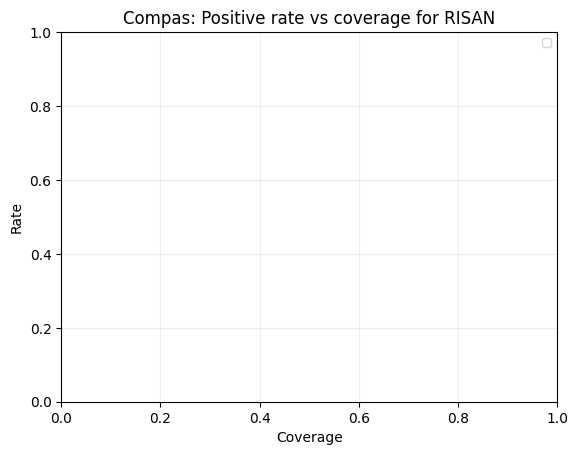

/tmp/ipykernel_143586/1727330689.py:78: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="small")


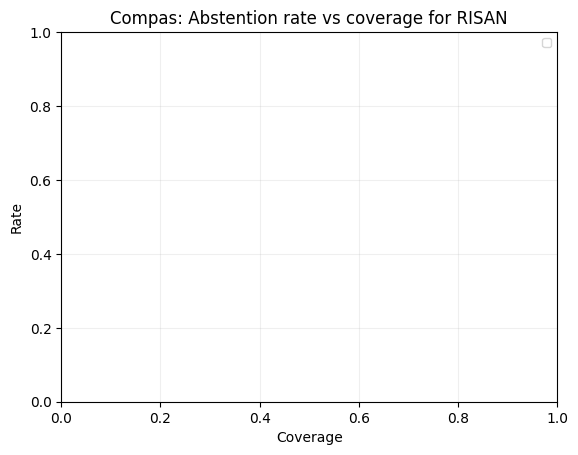

/tmp/ipykernel_143586/1727330689.py:87: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="small")


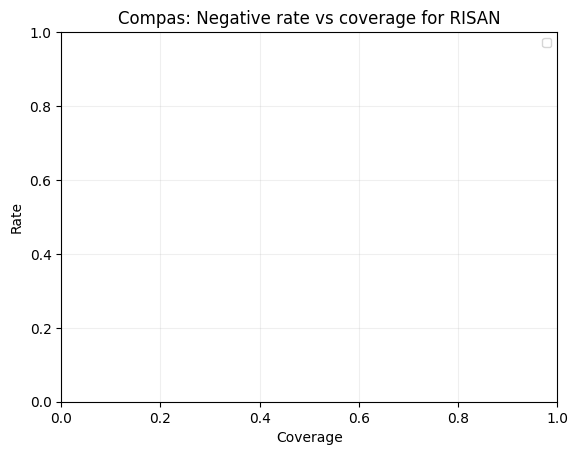

/tmp/ipykernel_143586/1727330689.py:96: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="small")


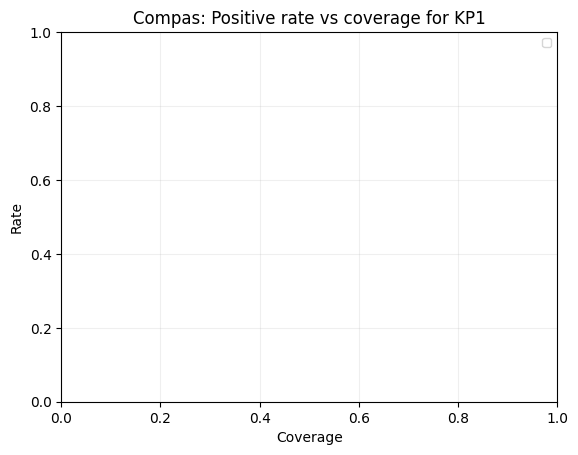

/tmp/ipykernel_143586/1727330689.py:105: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="small")


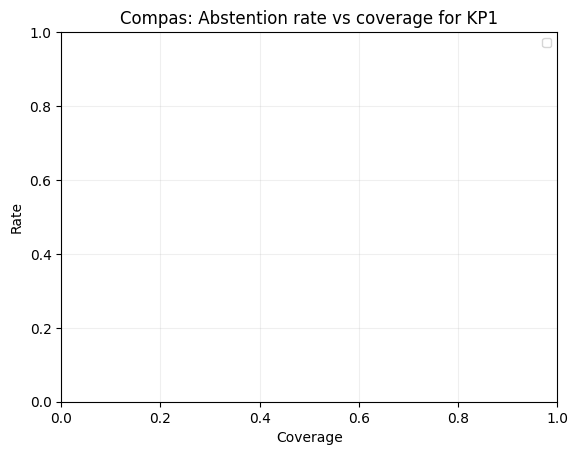

/tmp/ipykernel_143586/1727330689.py:114: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="small")


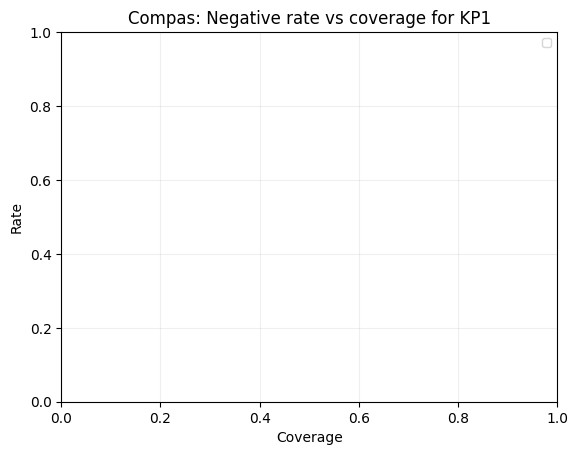

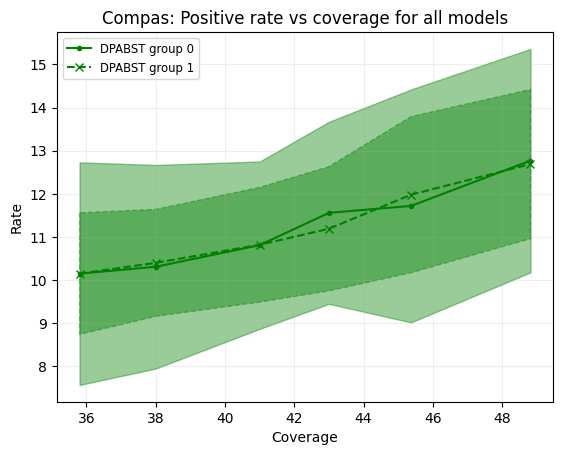

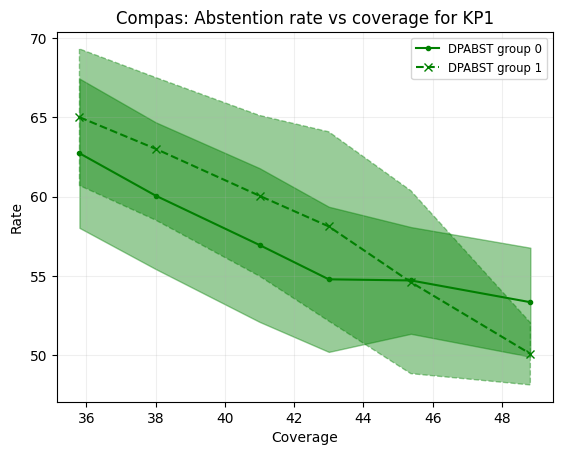

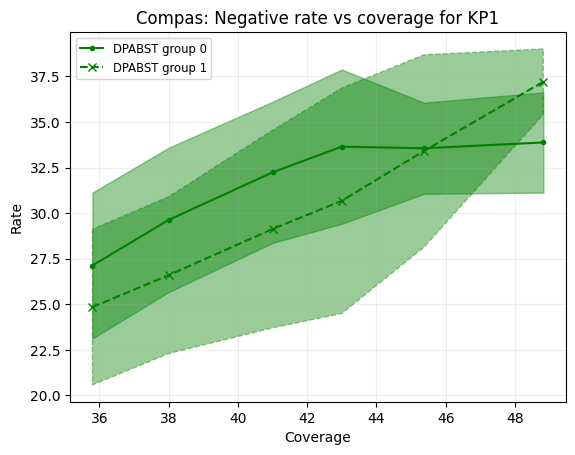

Average violation of fairness constraints
    model   pos   neg  abs
0  dpabst  0.14  2.48  2.5
Median violation of fairness constraints
    model   pos  neg   abs
0  dpabst  0.08  3.0  3.02
Max violation of fairness constriants
    model   pos   neg   abs
0  dpabst  0.37  3.33  3.33
Min violation of fairness constraints
    model  pos   neg   abs
0  dpabst  0.0  0.15  0.11


In [7]:
plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Accuracy vs coverage")
plt.xlabel("Coverage")
plt.ylabel("Accuracy")
plt.grid(alpha=0.2)
plots(dataframes, "acc", True, False, False)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate difference vs coverage")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plt.grid(alpha=0.2)
plots(dataframes, "pos", False, False, True)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Abstention rate difference vs coverage")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plt.grid(alpha=0.2)
plots(dataframes, "abs", False, False, True)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative rate difference vs coverage")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plt.grid(alpha=0.2)
plots(dataframes, "neg", False, False, True)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate vs coverage for DPABST")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["dpabst"]}, "pos", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Abstention rate vs coverage for DPABST")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["dpabst"]}, "abs", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative rate vs coverage for DPABST")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["dpabst"]}, "neg", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "pos", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Abstention rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "abs", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "neg", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "pos", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Abstention rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "abs", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "neg", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots(dataframes, "pos", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Abstention rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots(dataframes, "abs", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots(dataframes, "neg", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()

print("Average violation of fairness constraints")
print_table(dataframes, ["pos", "neg", "abs"], np.average)
print("Median violation of fairness constraints")
print_table(dataframes, ["pos", "neg", "abs"], np.median)
print("Max violation of fairness constriants")
print_table(dataframes, ["pos", "neg", "abs"], np.max)
print("Min violation of fairness constraints")
print_table(dataframes, ["pos", "neg", "abs"], np.min)